# **PREREQUISITES**
To best understand the paper, it is good to first deal with the mathematical prerequisites. This notebook will cover the mathematical concepts that underlie forward gradients, including automatic differentiation.

### **0. Introduction**
Many optimization algorithm (i.e. Stochastic Gradient Descent (SGD), RMSProp, Adam, etc) make use of gradient of an objective function $f$ (denoted $\nabla f$) to find the best coefficients that minimizes the function $f$ (i.e. $f$ could be the loss function). To do so, there are several differentiation techniques that we can try; among them, we will discuss **numerical differentiation** and **automatic differentiation**.


Before proceeding, let's import some needed tools...

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.autograd.forward_ad as fwAD
import functorch

import warnings
warnings.filterwarnings("ignore")

### **1. Numerical Differentiation**
Numerical differentiation is the finite difference approximation of derivatives using values of the original function evaluated at some sample points [7]. In its simplest form, it is based on the limit definition of a derivative. 

The following sections will introduce the concepts of derivative, partial derivative and directional derivative, with a final section explaining the concept of steepest ascent.

#### **1.1 Derivatives**
The derivative [1] of a function $f:\mathbb{R}\to\mathbb{R}$ of a single variable at a chosen input value $x$, when it exists, is the slope of the tangent line to the graph of the function at that point, and the tangent line is the best linear approximation of the function near that input value.

Given a function $f$ and a scalar $x\in\mathbb{R}$, the derivative of $f$ w.r.t. $x$ (namely $\partial f/\partial x$) can be computed as:
$$f^\prime(x) = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$$

##### **Example [1.1]**
Given the function $f(x)=-x^2$ with $x \in [-3, 3]\subseteq\mathbb{R}$, you can display the derivative (slope) at a point $x_0=-1$ by running the following code:

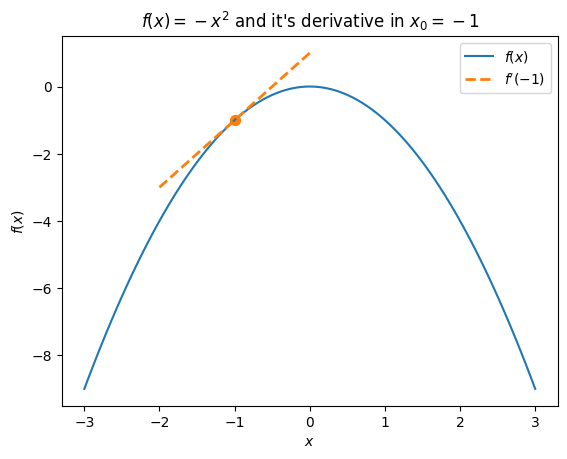

In [2]:
# define x
x0 = -1

# Define a function and it's tagent
def f1(x):
  return -x**2

def tangent1(x, x0):
  return f1(x0) - 2 * x0 * (x - x0)

# Generate x values in the range [-3, 3] 
xD = np.linspace(-3, 3, 100)

# Define x data range for tangent line
trange = np.linspace(x0-1, x0+1, 100)

# Plot title
plt.title(r"$f(x)=-x^2$ and it's derivative in $x_0="+f"{x0}$")

# Plot f, f' and x0
plt.plot(xD, f1(xD), label=r"$f(x)$")
plt.plot(trange, tangent1(trange, x0), 'C1--', linewidth=2, label=r"$f^\prime("+f"{x0})$")
plt.scatter(x0, f1(x0), color='C1', s=50)

# Add labels and legend
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend()
plt.show()

#### **1.2 Partial Derivatives**
Partial derivatives tell us how much a function would change when we keep all but one of its input variables constant and move a slight nudge in the direction of the one variable that is not fixed.

Suppose that $f$ is a function that depends on more than one variable, for instance: 
$$f(x_1, x_2) = x_1^2+x_2^2+x_1x_2$$
than $f$ can be reinterpreted as a family of functions of one variable indexed by the other variables: $f(x_1, x_2) = f_{x_1}(x_2)$. By fixing $x_1$ to a value "$a$", we get a function of a single variable $f_a(x_2)=a^2+x_2^2+a x_2$ and the derivative of this function is $f_a^\prime(x_2) = 2x_2+a$. The above procedure can be performed for any choice of $a$, and assembling the derivatives together into a function gives a function that describes the variation of $f$ in the $x_2$ direction: 
$\frac{\partial f}{\partial x_2}(x_1, x_2)=2x_2+x_1$; this is the partial derivative of $f$ with respect to $x_2$. 

Recalling that the gradient packs together all the partial derivative into a vector, the gradient of this function would be:
$$\nabla f(\mathbf{x}) = (2x_1+x_2, 2x_2+x_1)$$

In general, the partial derivative of a function $f(x_1,..., x_n)$ in the direction $x_i$ at the point $(a_1, ..., a_n)$ is defined to be:
$$\frac{\partial f}{\partial x_i}(a_1, ..., a_n)=\lim_{h \to 0}\frac{f(a_1,...,a_i+h,...a_n)+f(a_1,...,a_i,...,a_n)}{h}$$

##### **Example [1.2]**
Given, for example, the function $f(\mathbf{x})=-x_1^2-x_2^2$ with $\mathbf{x} \in [-3, 3]^2\subseteq\mathbb{R}^2$, you can display the tangent plane at a point $x_0=(-0.5, -2)$ by running the following code:

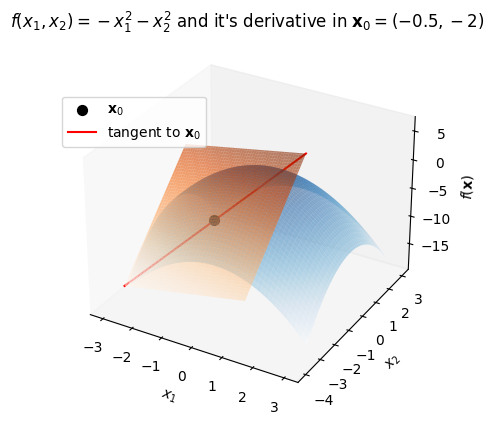

In [3]:
# define x0
x0 = [-0.5, -2]

# Define the function and it's tangent
def f2(x):
    return -(x[0]**2 + x[1]**2)

def tangent2(x, x0):
    return f2([x0[0],x0[1]]) - 2*(x[0]-x0[0])*x0[0] - 2*(x[1]-x0[1])*x0[1]

# Create a grid of x1 and x2 values
t1 = np.linspace(-3, 3, 100)
t2 = np.linspace(-3, 3, 100)
T1, T2 = np.meshgrid(t1, t2)

# Define x data range for tangent plane
t1r = np.linspace(x0[0]-2, x0[0]+2, 100)
t2r = np.linspace(x0[1]-2, x0[1]+2, 100)
T1r,T2r = np.meshgrid(t1r, t2r)

# Create a plot, disable grid, and add a title
ax = plt.axes(projection='3d')
ax.grid(False)
plt.title(r"$f(x_1,x_2)=-x_1^2-x_2^2$ and it's derivative in $\mathbf{x}_0=" + f"({x0[0]}, {x0[1]})" +"$")

# Plot f, f', x0 and a possible tangent
ax.plot_surface(T1, T2, f2([T1, T2]), cmap='Blues', alpha=0.5)
ax.plot_surface(T1r, T2r, tangent2([T1r, T2r], x0), cmap='Oranges', alpha=0.6)
ax.scatter3D(x0[0], x0[1], f2([x0[0], x0[1]]), color='k', s=50, label=r'$\mathbf{x}_0$')
ax.plot(t1r, t2r, tangent2([t1r, t2r], x0), color='r', label=r'tangent to $\mathbf{x}_0$')

# Add labels
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$f(\mathbf{x})$')
plt.legend(loc=(0,.7))
plt.show()

At $x_0=(-0.5, -2)$, as the gradient of the function is $\nabla f(x) = [-2x_1, -2x_2]=[1,4]$, a slight nudge purely in the $x_1$ direction would cause a change by a factor of 1 in the output of the function while a similar change in the $x_2$ direction would change the output of the function by a factor of 4.

#### **1.3 Directional Derivatives**

If $f$ is a real-valued function on $\mathbb{R}^n$, then the partial derivatives of $f$ measure its variation in the direction of the coordinate axes. For example, if $f$ is a function of $x_1$ and $x_2$, then its partial derivatives measure the variation of $f$ in the $x_1$ and $x_2$ direction. They do not, however, directly measure the variation of $f$ in any other direction, but these are measured using **directional derivatives**.

In higher dimensions, we have a lot of options to define tangents of graphs. Take plot of *example 1.2* as an example: for the black dot on the surface of $f(x_1, x_2)$, we can define as many tangents as we like; a possible choice could be the red line in the plot.

By defining some $\mathbf{v} = (v_1, v_2)$, we could choose the tangent pointing in the same direction of $\mathbf{v}$, and this slope happens to be $\nabla_\mathbf{v} f(\mathbf{x})$: that's the **directional derivative**. 



The directional derivative of a multivariable differentiable (scalar) function along a given vector $\mathbf{v}=(v_1, ..., v_n)$ at a given point $\mathbf{x}$ represents the instantaneous rate of change of the function, moving through $x$ with a velocity specified by $\mathbf{v}$. 
Given a vector $\mathbf{v}=(v_1, ..., v_n)$, the directional derivative of $f$ in the direction of $\mathbf{v}$ at the point $x$ is the limit:
$$\nabla_\mathbf{v} f(\mathbf{x})=\lim_{h \to 0}\frac{f(\mathbf{x}+h\cdot\mathbf{v})-f(\mathbf{x})}{h}$$
Moreover, $\nabla_\mathbf{v} f(\mathbf{x})$ is a scalar, just like $\nabla f(\mathbf{x})$, but for each value of $\mathbf{v}$ it's a different number, indicating the slope of $f$ in the $\mathbf{v}$ direction. It's possible to prove that:
$$\nabla_\mathbf{v} f(\mathbf{x}) = \nabla f(\mathbf{x})\cdot\mathbf{v}$$

##### **Example [1.3]**
As an example, given $f(x_1, x_2)=-x_1^2-x_2^2$, by choosing $\mathbf{v}=(4,2)$ we have that $\nabla_\mathbf{v} f(\mathbf{x})=(-2x_1, -2x_2)\cdot(4,2)^\top=-8x_1-4x_2$ and, by evaluationg the directional derivative in $\mathbf{x}=(-0.5, -2)$ we have that $\nabla_\mathbf{v} f(\mathbf{x})=4+4=8$. This means that, given that we are at the point $\mathbf{x}=(-0.5, -2)$ in our input plane, taking a tiny step in the direction of the vector $\mathbf{v}=(4, 2)$ would change the output of our function by a factor of 8.


#### **1.4 Direction of Steepest Ascent**
When training Neural Networks, the problem we seek to solve is that we want to know the direction that would result in the greatest increase in our loss, given that we are at a point $\mathbf{x}$. Once we know this direction we take a step in the opposite direction which would lead to the greatest reduction in the loss. 

The directional derivative can actually help us measure how good (or bad) a particular direction is. A possible way to solve this problem could be to find all the directional derivatives (considering all possible directions in wich we could move) and then choose the best direction as the one with the largest directional derivative. However, testing all possible direction would be costly.

Our goal is to find: 
$$\max_{\lvert\mathbf{v}\rvert=1} \nabla f(\mathbf{x})\cdot\mathbf{v}$$
By fixing the magnitude (lenght) of the vector to $\lvert\mathbf{v}\rvert=1$, we ensure not to pick vector based on a lager magnitude, but on the direction only.

Recalling that the dot product between two vectors $\vec{u}$ and $\vec{v}$ is:
$$\vec{u}\cdot\vec{v}=\lvert\vec{u}\rvert\cdot\lvert\vec{v}\rvert\cdot\cos\alpha$$
where $\alpha$ is the angle between $\vec{u}$ and $\vec{v}$, it's evident that two vector pointing in the same direction will have a larger dot product (higher *similarity*). 

As the directional derivative is the dot product $\nabla_\mathbf{v} f(\mathbf{x}) = \nabla f(\mathbf{x})\cdot\mathbf{v}$, the vector $\mathbf{v}$ that would maximize the directional derivative (and result in the greatest increase in our function) is the vector that points in the same direction as the gradient, which is the gradient itself. This is why **the gradient is the direction of steepest ascent**, and gradient descent takes a step in the opposite direction.

##### **Examle [1.4]**
As an example, you can observe the iterations of the Gradient Descent (**GD**) algorithm on the function $f(x_1, x_2)=x_1^2+x_2^2$ by running the code below: starting from $\mathbf{x}_0=(-15,15)$ we will see, iteratively, how the points are directed to the local minima of $f$:

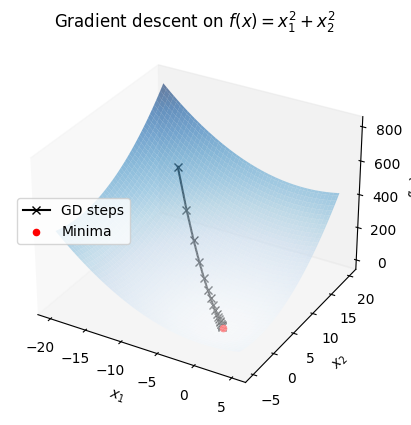

In [4]:
# Define the initial values of x0
x0 = np.array([-15, 15])

# Define SDG iterations number
iters = 20

# Define the function
def f3(x):
    return x[0]**2 + x[1]**2

# Define the gradient of the cost function
def gradient3(x):
    return np.array([2*x[0], 2*x[1]])

# Define the parameters for the plot
t1 = np.linspace(-20, 5, 100)
t2 = np.linspace(-5, 20, 100)
T1, T2 = np.meshgrid(t1, t2)

# Set the learning rate
alpha = 0.1

# Initialize list of gradients
grads = list()

# Perform gradient descent and save points in x_list
x_list = [x0.copy()]
for i in range(iters):
    grad = gradient3(x0)
    grads.append(grad)
    x0 = x0 - alpha * grad
    x_list.append(x0.copy())
x_list = np.array(x_list)
grads = np.array(grads)

# Create a plot, disable grid, and add a title
ax = plt.axes(projection='3d')
ax.grid(False)
plt.title(r"Gradient descent on $f(x)=x_1^2+x_2^2$")

# Plot f, GD steps and minima
ax.plot_surface(T1, T2, f3([T1, T2]), cmap='Blues', alpha=0.6)
ax.plot(x_list[:, 0], x_list[:, 1], f3([*x_list.T]), '-x', color='black', label="GD steps", alpha=1)
ax.scatter(0, 0, 0, color='r', label='Minima')

# Add labels and legend
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$f(x)$')
plt.legend(loc='center left')
plt.show()

---

### **2. Automatic Differentiation**

Automatic Diffeentiation [5] is reffered to a set of techniques to evaluate the derivative of a function specified by a computer program. As every computer program executes a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.) and elementary functions (exp, log, sin, cos, etc.), by applying the chain rule repeatedly to these operations, derivatives of arbitrary order can be computed automatically.
We can proceed to automatically compute the individual components of the gradient in two different ways:
1. **Forward Accumulative Mode**: in forward accumulation AD, one first fixes the independent variable with respect to which differentiation is performed and computes the derivative of each sub-expression recursively. 
2. **Reverse Accumulative Mode**: In reverse accumulation AD, the dependent variable to be differentiated is fixed and the derivative is computed with respect to each sub-expression recursively. Reverse mode AD is what we commonly refer to as **backpropagation** in Deep Learning. 

Before introducing automatic differentiation, let's introduce the concept of *dual numbers*.

#### **2.1 Dual Numbers**
Dual numbers [4][5] are a hypercomplex number of system of the form $v+\dot v\epsilon$ where $v,\dot v\in\mathbb{R}$ and $\epsilon$ is a symbol taken to satisfy $\epsilon^2=0$ with $\epsilon \not = 0$. 
Dual numbers can be added component-wise by $(v+\dot v\epsilon)+(u+\dot u\epsilon) = (v+u)+(\dot v+\dot u)\epsilon$, or multiplied by the formula $(v+\dot v\epsilon)(u+\dot u\epsilon)=vu+(v\dot u+\dot v u)\epsilon$.
Furthermore, one can algebraically derive the following:
$$f(x)=f(v+\dot v\epsilon)=f(v)+f^\prime(v)\dot v\epsilon $$
that means, by evalating a function $f$ at $v+\dot v\epsilon$ we also get its derivative "*for free*". The solution is also exact, as we don't ignore high orde derivatives nut we eliminate them.

Moreover, the chain rule of $f(g(x))$ using dual numbers becomes:
$$f(g(a+b\epsilon))=f(g(a)+g^\prime(a)b\epsilon)=f(g(a))+f^\prime(g(a))g^\prime(a)b\epsilon$$
so, the coefficient of $\epsilon$ on the right-hand side is exactly the derivative of the composition of $f$ and $g$. This means that we can easily propagate gradients across the layers of computation simply be multiplying derivatives with each other.

Given a dual number $v+\dot v\epsilon$ it is common to call $v$ the **primal**, since it represents the primary component of the computation, and $\dot v$ the **tangent**, giving a nod to the fact that it represents a derivative, which lives in a tangent space [8].

##### **Example [2.1]**
Given a function $f(x)=x^2+1$, to compute it's derivative using automatic differentiation we evaluate $f(x+\epsilon)=(x+\epsilon)^2+1=(x^2+1)+2x\epsilon$ thus we can conclude that $2x$ (the $\epsilon$ coefficient) is the derivative of $x^2+1$.

##### **Example [2.2]**
Given a function $f(x)=x^2+x$ we have $f(x+\epsilon)=(x+\epsilon)^2+(x+\epsilon)=x^2+\epsilon^2+2x\epsilon+x+\epsilon=(x^2+x)+(2x+1)\epsilon$, so the derivative of $f(x)$ is $2x+1$ (the $\epsilon$ coefficient).


#### **2.2 Forward Mode Differentiation**
Both forward and reverse AD mode have, as first task, to represent the function as a computational graph (also called **Wengert** list). Each node in this list will represent an intermediate result of the computation, that can be assembled together using the chain rule to otain the final derivative. 

For example, given the function $y = f(x_1, x_2)=x_1x_2-\sin(x_2)$, we would like to evaluate it's derivative $f^\prime(2,3)$. The computational graph for this function would be:

![alt text](diagram.png "Title")

And we want to compute $\partial y / \partial x_2$. This problem can be broken down into calculating derivatives of each intermediate node with respect to the input: 
$$\dot v_i = \frac{\partial v_i}{\partial \mathbf{x}}$$

To do so, for each input variable we now have to compute:

1. **Primal trace**: used to stores all the intermediate computations of each node: $v_1=x_1=2, v_2 =x_2=3, v_3=v_1\times v_2=6, v_4=\sin(v_2)=\sin(3), v_5=v_3-v_4=6-\sin(3)$
2. **Dual trace**: used to compute $\dot v_5$ by differentiating all $v_i$ by $x_2$: $\dot v_1=\partial x_1/\partial x_2=0, \dot v_2=\partial x_2/\partial x_2=1, \dot v_3=\dot v_1 v_2+v_1\dot v_2=2, \dot v_4=\partial\sin(v_2)/\partial v_2=\cos(v_2)=\cos(3), \dot v_5=\dot v_3-\dot v_4=2-\cos(3) \approx 1$.

As we compute $\dot v_i$ at the same time as $v_i$, then we can calculate a derivative at the same time as evaluating a function with no memory overhead. For this example we computed the derivative only for $x_2$, but this process should also be repeated for $x_1$. In general, this process should be repeated for each input variable.

In the general case we have functions $f:\mathbb{R}^n\to\mathbb{R}^m$ with $n$ independent (input) variables $x_i$ and $m$ dependent (output) variables $y_j$.  In this case, each forward pass of AD is initialized by setting only one of the variables $\dot x_i = 1$ and setting the
rest to zero; a run of the code then computes $\dot y_j=\partial y_j/\partial x_i$ for $j = 1, \dots, m$, thus giving us one column of the Jacobian matrix: 
$$J_f = \begin{bmatrix}\partial y_1/\partial x_1 & \cdots & \partial y_1/\partial x_n \\ \vdots & \ddots & \vdots \\ \partial y_m/\partial x_1 & \cdots & \partial y_m/\partial x_n\end{bmatrix}$$
where $x_i$ is the $i$-th input and $y_j$ is the $j$-th output. Thus, the full jacobian can be computed in $n$ evaluations.

##### **Example [2.3]**
Given $f(x_1, x_2)=x_1^2+x_2^2$, for multiple $x$ values, it's jacobian is $J_f(x_1, x_2)=\begin{bmatrix}\partial y_1/\partial x_1 && \partial y_1/\partial x_2 \\ \vdots &&  \vdots \\ \partial y_m/\partial x_1 && \partial y_m/\partial x_2 \end{bmatrix}=\begin{bmatrix} 2x_{1,1} && 2x_{2,1} \\ \vdots && \vdots \\ 2x_{1,m} && 2x_{2,m} \end{bmatrix}$. For $x_1=\begin{bmatrix}1&4\end{bmatrix}$ and $x_2=\begin{bmatrix}3&2\end{bmatrix}$ we have that $J_f(x)=\begin{bmatrix}2 && 6 \\ 8 && 4 \end{bmatrix}$:

In [5]:
def f4(x1, x2):
  return x1**2 + x2**2

inputs = (torch.tensor([1.,4.]), torch.tensor([3.,2.]))
jacobian = torch.autograd.functional.jacobian(f4, inputs)
print("dy/dx1 =", jacobian[0][0]+jacobian[0][1],
      "\ndy/dx2 =", jacobian[1][0]+jacobian[1][1])

dy/dx1 = tensor([2., 8.]) 
dy/dx2 = tensor([6., 4.])


Furthermore, forward mode AD provides a very efficient and matrix-free way of computing Jacobian–vector products (JVP):
$$\mathbf{J}_f\mathbf{v}=\begin{bmatrix}\partial y_1/\partial x_1 & \dots & \partial y_1/\partial x_n \\ \vdots & \ddots & \vdots \\ \partial y_m/\partial x_1 & \dots & \partial y_m/\partial x_n\end{bmatrix}\begin{bmatrix}v_1 \\ \vdots \\ v_n\end{bmatrix}$$
where $J_f(x)\in\mathbf{R}^{m\times n}$ is the jacobian matrix of all partial derivatives of $f$ evaluated at $x$, $\mathbf{v}$ is a perturbation vector, and $\partial y/\partial x_i=\begin{bmatrix}\partial y_1/\partial x_i & \cdots & \partial y_m/\partial x_i \end{bmatrix}$ are the partial derivatives of the outputs with respect to the $i$-th input.

For the case of $f:\mathbb{R}^n\to\mathbb{R}$, the Jacobian-vector product corrisponds to the directional derivative $\nabla f(\mathbf{x})\cdot\mathbf{v}$ wich is the projection of the gradient $\nabla f(\mathbf{x})$ onto the direction vector $\mathbf{v}$, representing the rate of change along that direction.

As, for each $x_i$ we need to compute a primal and dual trace, forward mode suffers when $n$ is large. As most learning algorith have $n\gg m$ it's often convenient to use reverse mode instead (i.e backpropagation).

The techniques described so fare are the core of **forward-mode automatic differentiation**.

In Pytorch, it's possible to use forward-mode AD to compute a directional derivative by performing the forward pass, except we first associate our input with another tensor representing the direction of the directional derivative (or equivalently, the $\mathbf{v}$ in a Jacobian-vector product). When an input, which we call "primal", is associated with a "direction" tensor, which we call "tangent", the resultant new tensor object is called a "*dual tensor*" for its connection to dual numbers [4].

##### **Example [2.4]**

Given a function $f(x_1,x_2)=x_1^2+x_2^2+x_1x_2$, the derivatives $\partial f/\partial x_1=2x_1+x_2$, and $\partial f/\partial x_2=2x_2+x_1$ can be computed using dual numbers as follows:

In [6]:
print("f(x1,x2)=x0^2+x1^2+x1*x2 \ndf/dx1 = 2x1+x2 \ndf/dx2 = 2x2+x1\n")

# Define the function
def f5(x1, x2):
    return x1 ** 2 + x2 ** 2 + x1 * x2

# Define primals and tangent
x1 = torch.tensor([1.,2.,1.])
x2 = torch.tensor([3.,1.,4.])
tangent = torch.ones(3)

# All forward AD computation must be performed in the context of
# a ``dual_level`` context.
with fwAD.dual_level():
    # Dual input/output using theha1 as primal
    dual_input1 = fwAD.make_dual(x1, tangent)    
    dual_output1 = f5(dual_input1, x2)

    # Dual input/output using theha2 as primal
    dual_input2 = fwAD.make_dual(x2, tangent)       
    dual_output2 = f5(dual_input2, x1)

    # Unpack the dual numbers (to get primals and tangents)
    jvp1 = fwAD.unpack_dual(dual_output1)
    jvp2 = fwAD.unpack_dual(dual_output2)

    # Iterate over the unpacked dual numbers and print results
    for j in range(len(x1)):
        print(f'f{x1[j].item(), x2[j].item()} = ' +
              f'{jvp1.primal[j]}, '+
              f'df/dx1 = {jvp1.tangent[j]}, ' +
              f'df/dx2 = {jvp2.tangent[j]}')

f(x1,x2)=x0^2+x1^2+x1*x2 
df/dx1 = 2x1+x2 
df/dx2 = 2x2+x1

f(1.0, 3.0) = 13.0, df/dx1 = 5.0, df/dx2 = 7.0
f(2.0, 1.0) = 7.0, df/dx1 = 5.0, df/dx2 = 4.0
f(1.0, 4.0) = 21.0, df/dx1 = 6.0, df/dx2 = 9.0


Alternatively, we could easily use the jacobian-vector product to do the previous task. By defining two tangents $\mathbf{v}_1=\mathbf{v}_2=\begin{bmatrix}1\end{bmatrix}$, the jacobian vector product will compute:
$$\mathbf{J}_f\mathbf{V}=\begin{bmatrix}\partial y_1/\partial x_1 & \partial y_1/\partial x_2 \\ \partial y_2/\partial x_1 & \partial y_2/\partial x_2 \\ \partial y_3/\partial x_1 & \partial y_2/\partial x_2\end{bmatrix}\begin{bmatrix}1\\1\end{bmatrix}=\begin{bmatrix}\partial y_1/\partial x_1 + \partial y_1/\partial x_2 \\ \partial y_2/\partial x_1 + \partial y_2/\partial x_2 \\ \partial y_3/\partial x_1 + \partial y_2/\partial x_2\end{bmatrix}$$

In [7]:
# Define primals and tangents
primals = (x1, x2)
tangents = (torch.ones(3), torch.ones(3))

# Compute and print the JVP
print(f'df/dx1+df/dx2 = {functorch.jvp(f5, primals, tangents)[1]}')

df/dx1+df/dx2 = tensor([12.,  9., 15.])


If we want to compute the derivatives w.r.t. just a single input variable (i.e. $x_1$ or $x_2$), than we just have to change the vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ (i.e. by setting $\mathbf{v}_1=\begin{bmatrix}1&1&1\end{bmatrix}$ and $\mathbf{v}_2=0^\top$ for $x_1$, and viceversa for $x_2$):

In [8]:
print(f'df/dx1 = {functorch.jvp(f5, primals, (torch.ones(3), torch.zeros(3)))[1]}')
print(f'df/dx2 = {functorch.jvp(f5, primals, (torch.zeros(3), torch.ones(3)))[1]}')

df/dx1 = tensor([5., 5., 6.])
df/dx2 = tensor([7., 4., 9.])


##### **Example [2.5]**
Given a function $f(\mathbf{x})=x_1^2+x_2^3+3x_3$ we have that $\nabla f(\mathbf{x})=\begin{bmatrix}\partial f/\partial x_1 & \partial f/\partial x_2 & \partial f/\partial x_3\end{bmatrix}=\begin{bmatrix}2x_1 & 2x_2+x_3 & x_2\end{bmatrix}$. Partial derivatives can be computed by running the following code:

In [9]:
# Define the function
def f6(x1, x2, x3):
    return x1**2 + x2**2 + x3*x2

# Define x1, x2, x3
x1 = torch.tensor([1.,2.,1.])
x2 = torch.tensor([3.,1.,4.])
x3 = torch.tensor([1.,1.,1.])

# Define primals
primals = (x1, x2, x3)

# Compute and print the partial derivatives using JVP
print(f'df/dx1 = {functorch.jvp(f6, primals, (torch.ones(3), torch.zeros(3), torch.zeros(3)))[1]}')
print(f'df/dx2 = {functorch.jvp(f6, primals, (torch.zeros(3), torch.ones(3), torch.zeros(3)))[1]}')
print(f'df/dx3 = {functorch.jvp(f6, primals, (torch.zeros(3), torch.zeros(3), torch.ones(3)))[1]}')

df/dx1 = tensor([2., 4., 2.])
df/dx2 = tensor([7., 3., 9.])
df/dx3 = tensor([3., 1., 4.])


---

### **3. Forward Gradient**

Given a function $f:\mathbb{R}^n\to\mathbb{R}$, the forward gradient $\mathbf{g}:\mathbb{R}^n\to\mathbb{R}^n$ is defined as:
$$\mathbf{g}_\mathbf{v}(x):= \nabla_\mathbf{v} f(x)\cdot\mathbf{v}=(\nabla f(x)\cdot\mathbf{v})\mathbf{v}$$
where $x\in\mathbb{R}^n$ is the point at which we are evaluating
the gradient, $\mathbf{v}\in\mathbb{R}^n$ is a perturbation vector taken as a multivariate random variable $\mathbf{v}\backsim p(\mathbf{v})$ such that $\mathbf{v}$’s scalar components $v_i$ are independent and have zero mean and unit variance for all $i$, and $\nabla f(x)\cdot\mathbf{v}\in\mathbb{R}$ is the directional
derivative of $f$ at point $x$ in direction $\mathbf{v}$.

Moreover, the *forward gradient* $\mathbf{g}_\mathbf{v}(x)$ is an unbiased estimator of the gradient $\nabla f(x)$.

##### **Example [1.1]**
Let's now take as an example the function $f(x_1, x_2)=x_1^2+x_2^2$ for wich we want to compute the gradients at a given point $x_0=(-15,15)$. By computing the gradients manually we have that $\nabla f(x_1,x_2)=(2x_1, 2x_2)$ so $\nabla f(-15,15)=(-30,30)$; this can easily be verified by computing directional derivatives using the canonical basis, i.e. $\mathbf{v}=\begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix}$. By using a numerical differentiation [9] we get:

In [10]:
# Define x0
x0 = np.array([[-15, 15]])

# Define the function 
def f7(x):
    return x[:,0]**2 + x[:,1]**2

# Define h (very small) and vector v (as canonical base vectors)
h = 1e-10
v = np.array([[1, 0], [0, 1]])

# Compute ∇ᵥf(θ) using the numerical definition
grad_v_f = ((f7(x0 + h*v) - f7(x0)) / h)

# Scale v with grad_f to compute g
g = grad_v_f.reshape(-1, 1) * v

# Print result
print(f'Approximate derivative: {g.sum(axis=0)}') 

Approximate derivative: [-29.99968274  29.99968274]


Let's now compute several random vectors $\mathbf{v}$ and the forward gradients $\mathbf{g}_\mathbf{v}(x)$:

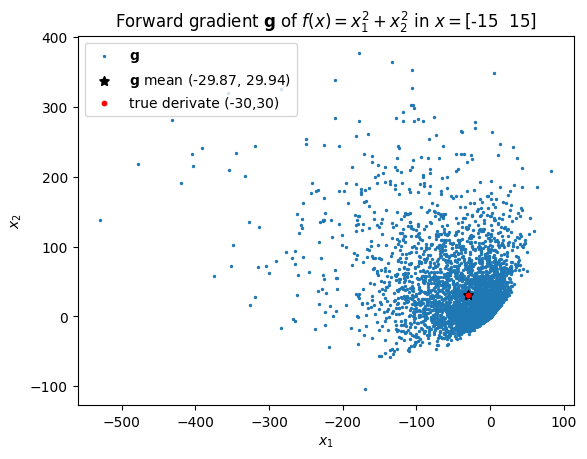

In [12]:
# Set a seed to keep it reproducible
np.random.seed(0) 

# Geneate a million random vectors of size 2
v = np.random.randn(1_000_000, 2)

# Compute ∇ᵥf(θ) using the numerical definition
grad_v_f = ((f7(x0 + h*v) - f7(x0)) / h)

# Scale v with grad_f to compute g
g = grad_v_f.reshape(-1, 1) * v

# Plot g, it's mean and true derivative
plt.scatter(g[:5000,0], g[:5000,1], s=2, label=r'$\mathbf{g}$')
plt.scatter(g.mean(axis=0)[0], g.mean(axis=0)[1], c='k', s=50, marker=(5, 1), label=r"$\mathbf{g}$ mean "+f'({g.mean(axis=0)[0]:.2f}, {g.mean(axis=0)[1]:.2f})')
plt.scatter(2*x0[0][0], 2*x0[0][1], c='r', s=10, label="true derivate "+f'({2*x0[0][0]},{2*x0[0][1]})')

# Add labels and legend
plt.title(r'Forward gradient $\mathbf{g}$ of $f(x)=x_1^2+x_2^2$ in $x=$'+f'{x0.sum(axis=0)}')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper left')
plt.show()

This time, although not the canonical basis $\mathbf{v}=\begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix}$ but random vectors were used, the result is the same. That's because, as $\mathbf{g}_\mathbf{v}(x)$ is an unbiased estimator of the gradient $\nabla f(x)$, by sampling many $\mathbf{v}$'s and computing (and average) the corresponding forward gradients, we end up with a pretty good approximation of the true gradient. In fact, as we can see from the plot, the mean of all the diretional derivatives is really close to the true derivative.

## **References**

[1] [Derivative](https://en.wikipedia.org/wiki/Derivative).

[2] Kofi Asiedu Brempong, 2020 [I Finally Understood Backpropagation: And you can too...](https://towardsdatascience.com/i-finally-understood-backpropagation-and-you-can-too-44f7dd98ff52).

[3] Atılım Gunes Baydin, Barak A. Pearlmutter, Don Syme, Frank Wood, Philip Torr, 2022. [Gradients without Backpropagation](https://arxiv.org/abs/2005.00817).

[4] [Dual number](https://en.wikipedia.org/wiki/Dual_number).

[5] Mark Saroufim, 2019. [Automatic Differentiation Step by Step](https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6).

[6] Robert Lange, 2019. [Forward Mode Automatic Differentiation & Dual Numbers](https://towardsdatascience.com/forward-mode-automatic-differentiation-dual-numbers-8f47351064bf).

[7] Atılım Gunes Baydin, Barak A. Pearlmutter, Alexey Andreyevich Radul, Jeffrey Mark Siskind, 2018. [Automatic Differentiation in Machine Learning: a Survey](https://www.jmlr.org/papers/volume18/17-468/17-468.pdf).

[8] Daniel Worrall, 2021. [Dual numbers](https://danielewworrall.github.io/blog/2021/08/dual-numbers/)

[9] Dr. Robert Kübler, 2022. [Papers Simplified: Gradients without Backpropagation](https://towardsdatascience.com/papers-simplified-gradients-without-backpropagation-96e8533943fc).